# Correction zone stability analysis

In [1]:
%matplotlib inline
from itertools import product as c_prdt
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from aux import Generic
from disp import set_font_size, get_ordered_colors, get_spaced_colors

## Analytical solution to stability map

We want to know how much a trajectory deviates over one temporal cycle as a function of its starting location and the correction zone parameters.

Let 

$$t^* = h/v_s + (1-h)/v_f$$

be the time it would take to pass through 1 spatial correction zone cycle if there were no temporal modulation.

The total displacement after one temporal cycle is

$\Delta x = (1-w)v_f + w//t^* + r_x(x_0)$

where the first term accounts for the time the temporal modulation is silent, the second term is the integer number ($n_c = w//t^*$) of complete correction zone cycles passed through  during while the temporal modulation is on ($w$) and $r_x$ is the leftover travel distance beyond the integer correction zone multiple, which depends on the starting point $x_0$.

The time not accounted for by the integer multiple of correction zones is

$$r_t = w - t^*(w//t*)$$

which is less than $t^*$ by construction.

Unfortunately there are 6 possible scenarios for $r_x$ as a func of $x_0$ (defined btwn 0 and 1):

1. $x$ starts inside and stays inside the czone. Occurs if $0 \leq x_0 < h$ and $r_t < (h - x_0)/v_s$. Then $r_x = v_sr_t$.
2. $x$ starts inside and ends up outside the czone. Occurs if $0 \leq x_0 < h$ and $(h - x_0)/v_s \leq r_t < (h-x_0)/v_s + (1-h)/v_f$. Then $r_x = h-x_0 + [r_t - (h - x_0)/v_s]v_f$.
3. $x$ starts inside, leaves, then renters the czone. Occurs if $0 \leq x_0 < h$ and $(h-x_0)/v_s + (1-h)/v_f \leq r_t$. Then $r_x = (1-h) + [r_t-(1-h)/v_f]v_s$.
4. $x$ starts outside and stays outside the czone. Occurs if $h \leq x_0 < 1$ and $r_t < (1 - x_0)/v_f$. Then $r_x = v_fr_t$
5. $x$ starts outside and ends up inside the czone. Occurs if $h \leq x_0 < 1$ and $(1 - x_0)/v_f \leq r_t < (1-x_0)/v_f + h/v_s$. Then $r_x = 1-x_0 + [r_t-(1 - x_0)/v_f]v_s$.
6. $x$ starts outside, enters, then leaves the czone. Occurs if $h \leq x_0 < 1$ and $(1-x_0)/v_f + h/v_f \leq r_t$. Then $r_x = h + [r_t-h/v_s]v_f$.

## Equilibrium trajectories

For eqbm trj, time in czone $t_s$ is given by $t_s + t_f = 1$ and $t_sv_s + t_fv_f = 1$, so 

$$t_s = \frac{v_f - 1}{v_f-v_s}$$

Stable eqbm trj ($0 \leq x_0^{stb} < 1$):

$$x_0^{stb} = 1 + \left[t_s - w\right]v_f$$

$$x_0^{stb} = 1+\left[\frac{v_f - 1}{v_f - v_s} - w\right]v_f$$

Unstable eqbm trj ($0 \leq x_0^{uns} < 1$):

$$x_0^{uns} = h - t_sv_s$$

$$x_0^{uns} = h - \left[\frac{v_f - 1}{v_f - v_s}\right]v_s$$

In angular units:

$$\phi^{stable} = 2\pi\left[ 1+\left[\frac{v_f - 1}{v_f - v_s} - w\right]v_f \right]$$


$$\phi^{unstable} = 2\pi\left[ h - \left[\frac{v_f - 1}{v_f - v_s}\right]v_s \right]$$

## Bounds of basin of attraction

Left bound (relative to stable point):

$$x_0^{uns} - x_0^{stb} = h + wv_f - \frac{v_f(v_f+v_s) - 2v_s}{v_f - v_s}.$$

Right bound (relative to stable point):

$$x_0^{uns} + 1 - x_0^{stb} = h + wv_f - (v_f-1)\frac{v_s+v_f}{v_f-v_s}.$$

In [2]:
N_X = 500
N_T = 1001

X_0 = np.linspace(-1, 1, 2*N_X)

T = np.linspace(0, 1, N_T)


def run_smln(x_0, w, h, v_f, v_s):
    """Simulate trj thru one temporal cycle."""
    x = np.nan * np.zeros(T.shape)
    x[0] = x_0
    
    for ct, t_ in enumerate(T[1:], 1):
        
        # set v slow if in czone else fast
        if (0 <= x[ct-1] % 1 < h) and (0 <= t_ % 1 < w):
            v = v_s
        else:
            v = v_f
            
        # update x
        x[ct] = x[ct-1] + v*(T[ct] - T[ct-1])
    return x


def calc_dx_s(x_0, w, h, v_f, v_s):
    """Calculate change in x (dx) relative to one spatial period (dx_s)."""
    
    x_0 = x_0 % 1  # constrain btwn 0 and 1
    
    t_star = h/v_s + (1-h)/v_f
    n_c = np.floor(w/t_star)
    r_t = w - t_star*n_c
    
    if 0 <= x_0 < h:  # starts in czone
        
        if r_t < (h-x_0)/v_s:  # stays in
            r_x = v_s*r_t
            
        elif (h-x_0)/v_s <= r_t < ((h-x_0)/v_s + (1-h)/v_f):  # leaves
            r_x = (h-x_0) + (r_t - (h-x_0)/v_s)*v_f
            
        elif ((h-x_0)/v_s + (1-h)/v_f) <= r_t:  # leaves and re-enters
            r_x = (1-h) + (r_t - (1-h)/v_f)*v_s
        
    elif (h <= x_0 < 1):  # starts out
        
        if r_t < (1-x_0)/v_f:  # stays out
            r_x = v_f*r_t
        
        elif (1-x_0)/v_f <= r_t < ((1-x_0)/v_f + h/v_s):  # enters
            r_x = 1-x_0 + (r_t - (1-x_0)/v_f)*v_s
        
        elif (1-x_0)/v_f + h/v_s <= r_t:  # enters, re-exits
            r_x = h + (r_t - h/v_s)*v_f
    
    dx = (1-w)*v_f + n_c + r_x
    return dx - 1


def chk_stb(w, h, v_f, v_s):
    """Check whether czone param set supports stable trjs."""
    
    # most lagged possible stable trj start pt
    x_0_lag = max(h, 1-w*v_f)  
    
    # most advanced possible stable trj start pt
    x_0_lead = 1 + min(0, (h/v_s - w)*v_f)  
    
    dx_s_lag = calc_dx_s(x_0_lag, w, h, v_f, v_s)
    dx_s_lead = calc_dx_s(x_0_lead, w, h, v_f, v_s)
    
    # make sure sign of change goes from neg to pos
    return (x_0_lag <= x_0_lead) and (dx_s_lead <= 0 <= dx_s_lag)


def get_basin(w, h, v_f, v_s):
    t_s = (v_f-1)/(v_f-v_s)
    
    x_0_stb = 1 + (t_s - w)*v_f
    x_0_uns = h - t_s*v_s
    
    lb = x_0_uns - x_0_stb
    ub = x_0_uns + 1 - x_0_stb
    
    return np.array([t_s, x_0_stb, x_0_uns, lb, ub])

Example stability map and trajectories

Stable solution exists: True
t_s, x_0_stb, x_0_uns, lb, ub:
 [ 0.33333333  0.68        0.3        -0.38        0.62      ]


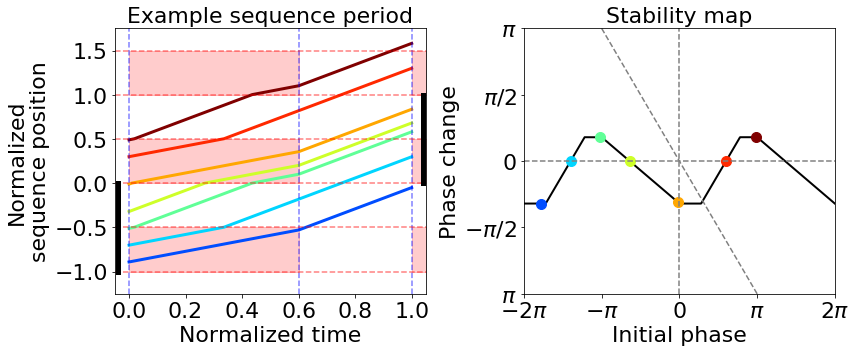

In [3]:
w = .6
h = .5

v_f = 1.2
v_s = .6

print('Stable solution exists:', chk_stb(w, h, v_f, v_s))
print('t_s, x_0_stb, x_0_uns, lb, ub:\n', get_basin(w, h, v_f, v_s))

t_s, x_0_stb, x_0_uns, lb, ub = get_basin(w, h, v_f, v_s)

x_0_xpl = np.array([
    x_0_stb+lb+.5*lb, x_0_stb+lb,
    x_0_stb+.5*lb, x_0_stb, x_0_stb+.5*ub,
    x_0_stb+ub, x_0_stb+ub-.5*lb]) - 1

lbc = .2
ubc = 1

c = get_ordered_colors('jet', len(x_0_xpl), .2, 1)

x_xpl = []
dx_s_xpl = []

for x_0 in x_0_xpl:
    x_xpl.append(run_smln(x_0, w, h, v_f, v_s))
    dx_s_xpl.append(calc_dx_s(x_0, w, h, v_f, v_s))

dx_s = np.array([calc_dx_s(x_0, w, h, v_f, v_s) for x_0 in X_0])


fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

# xpl trjs

for x, c_ in zip(x_xpl, c):
    axs[0].plot(T, x, color=c_, lw=3)

for t_, x_ in c_prdt((-1, 0, 1), (-1, 0, 1)):
    axs[0].fill_between([t_, t_ + w], [x_, x_], [x_ + h, x_ + h], color='r', alpha=.2)
    
axs[0].axvline(0, color='b', ls='--', alpha=.5)
axs[0].axvline(w, color='b', ls='--', alpha=.5)
axs[0].axvline(1, color='b', ls='--', alpha=.5)

for x_ in (-1, 0, 1):
    axs[0].axhline(x_, color='r', ls='--', alpha=.5)
    axs[0].axhline(x_ + h, color='r', ls='--', alpha=.5)
    
axs[0].plot([-.04, -.04], [-1, 0], c='k', lw=5)
axs[0].plot([1.04, 1.04], [0, 1], c='k', lw=5)

axs[0].set_xlim(-.05, 1.05)
axs[0].set_ylim(-1.25, 1.75)

axs[0].set_xlabel('Normalized time')
axs[0].set_ylabel('Normalized\nsequence position')
axs[0].set_title('Example sequence period')


# stability map
axs[1].plot(2*np.pi*X_0, 2*np.pi*dx_s, lw=2, c='k', zorder=0)

## locs of xpl trjs on stability map
for x_0, dx_s_, c_ in zip(x_0_xpl, dx_s_xpl, c):
    axs[1].scatter(2*np.pi*x_0, 2*np.pi*dx_s_, s=100, c=[c_], zorder=1)

axs[1].axhline(0, color='gray', ls='--')
axs[1].axvline(0, color='gray', ls='--')
axs[1].plot([-np.pi, np.pi], [np.pi, -np.pi], c='gray', ls='--')

axs[1].set_xlim(-2*np.pi, 2*np.pi)
axs[1].set_ylim(-np.pi, np.pi)

axs[1].set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[1].set_xticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])
axs[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axs[1].set_yticklabels(['$\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[1].set_xlabel('Initial phase')
axs[1].set_ylabel('Phase change')
#axs[1].set_title(
#    'Stability map\n$w = {},\:\:h = {},\:\:v_f = {},\:\:v_s = {}$'.format(w, h, v_f, v_s))
axs[1].set_title('Stability map')

for ax in axs:
    set_font_size(ax, 22)
    
fig.savefig('cosyne_poster_figs/fig2ab.svg')

## Correction timescale

True


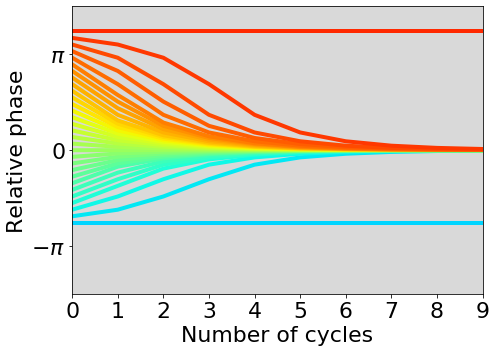

In [4]:
print(chk_stb(w, h, v_f, v_s))

def run_multi_pass(x_0, n, w, h, v_f, v_s):
    x_s = np.nan * np.zeros(n)
    x_s[0] = x_0
    for cp in range(1, n):
        x_s[cp] = x_s[cp-1] + calc_dx_s(x_s[cp-1], w, h, v_f, v_s)
    
    return x_s

t_s, x_0_stb, x_0_uns, lb, ub = get_basin(w, h, v_f, v_s)

fig, ax = plt.subplots(1, 1, figsize=(7, 5), tight_layout=True)

n_x_0 = 30
x_0 = np.linspace(x_0_stb+lb, x_0_stb+ub, n_x_0)
c_x_0 = get_ordered_colors('jet', n_x_0, *np.linspace(lbc, ubc, len(x_0_xpl))[[1, -2]])

for x_0_, c_ in zip(x_0, c_x_0):
    ax.plot(2*np.pi*(run_multi_pass(x_0_, 10, w, h, v_f, v_s)-x_0_stb), lw=4, c=c_)
    
ax.set_xlabel('Number of cycles')
ax.set_ylabel('Relative phase')

ax.set_xlim(0, 9)
ax.set_ylim(-1.5*np.pi, 1.5*np.pi)
ax.set_yticks([-np.pi, 0, np.pi])
ax.set_yticklabels(['$-\pi$', '0', '$\pi$'])

ax.set_facecolor((.85, .85, .85))

set_font_size(ax, 22)
fig.savefig('cosyne_poster_figs/fig2d.svg')

(0, 1)

/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


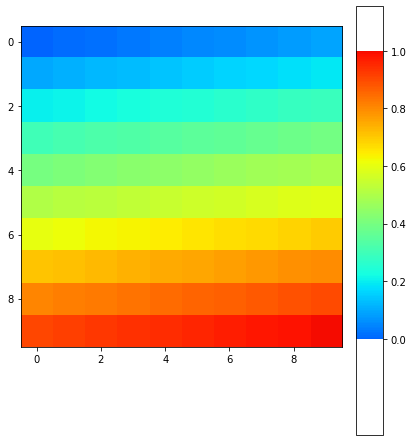

In [5]:
# colorbar
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
z = np.linspace(0, 1, 100).reshape(10, 10)
tmp_l, tmp_u = np.linspace(lbc, ubc, len(x_0_xpl))[[1, -2]]
v_min = -tmp_l
v_max = 1/tmp_u
c = ax.imshow(z, cmap='jet', vmin=v_min, vmax=v_max)
cax = plt.axes([1, 0.1, 0.075, 0.8])

plt.colorbar(c, cax=cax)
cax.set_ylim(0, 1)

## Attractor phase and basin bounds vs czone params

Vary w

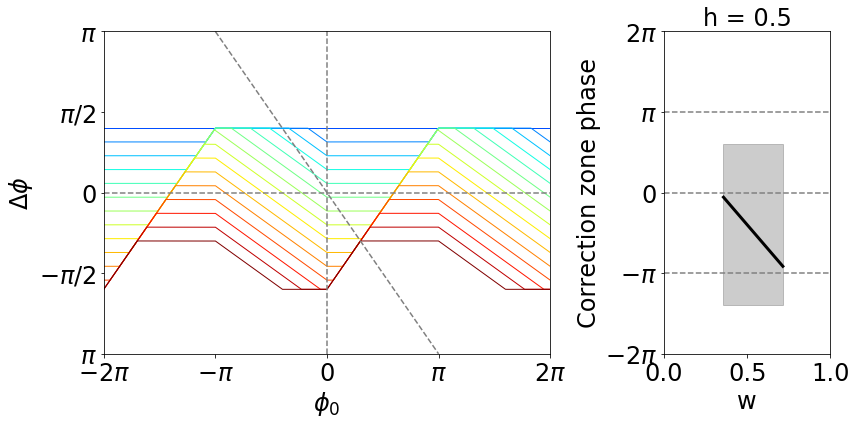

In [6]:
v_f = 1.2
v_s = 0.6

h = 0.5
w = np.linspace(0, 1, 15)

stb = np.zeros(len(w))
phi_stb = np.nan * np.zeros(len(w))
lb = np.nan * np.zeros(len(w))
ub = np.nan * np.zeros(len(w))

gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(12, 6), tight_layout=True)
axs = [fig.add_subplot(gs[:-1]), fig.add_subplot(gs[-1])]

c = get_ordered_colors('jet', len(w), .2, 1)

for cw, (w_, c_) in enumerate(zip(w, c)):
    # check stability
    stb[cw] = chk_stb(w_, h, v_f, v_s)
    
    # calc and store attractor basin
    if stb[cw]:
        _, x_0_stb_, _, lb_, ub_ = get_basin(w_, h, v_f, v_s)
        
        phi_stb[cw] = 2*np.pi*(x_0_stb_ - 1)
        lb[cw] = 2*np.pi*lb_
        ub[cw] = 2*np.pi*ub_
        
    # plot stability map
    dx_s = np.array([calc_dx_s(x_0, w_, h, v_f, v_s) for x_0 in X_0])
    axs[0].plot(2*np.pi*X_0, 2*np.pi*dx_s, lw=1, c=c_, zorder=0)

axs[0].axhline(0, color='gray', ls='--')
axs[0].axvline(0, color='gray', ls='--')
axs[0].plot([-np.pi, np.pi], [np.pi, -np.pi], c='gray', ls='--')

axs[0].set_xlim(-2*np.pi, 2*np.pi)
axs[0].set_ylim(-np.pi, np.pi)

axs[0].set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[0].set_xticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])
axs[0].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axs[0].set_yticklabels(['$\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].set_xlabel('$\phi_0$')
axs[0].set_ylabel('$\Delta \phi$')

axs[1].plot(w, phi_stb, lw=3, c='k')
axs[1].fill_between(w, phi_stb+lb, phi_stb+ub, color='k', alpha=.2)
axs[1].axhline(np.pi, color='gray', ls='--')
axs[1].axhline(0, color='gray', ls='--')
axs[1].axhline(-np.pi, color='gray', ls='--')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(-2*np.pi, 2*np.pi)

axs[1].set_xticks([0, .5, 1])
axs[1].set_yticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[1].set_yticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])

axs[1].set_xlabel('w')
axs[1].set_ylabel('Correction zone phase')
axs[1].set_title('h = {}'.format(h))

for ax in axs:
    set_font_size(ax, 24)
    
fig.savefig('cosyne_poster_figs/fig2c1.svg')

Vary h

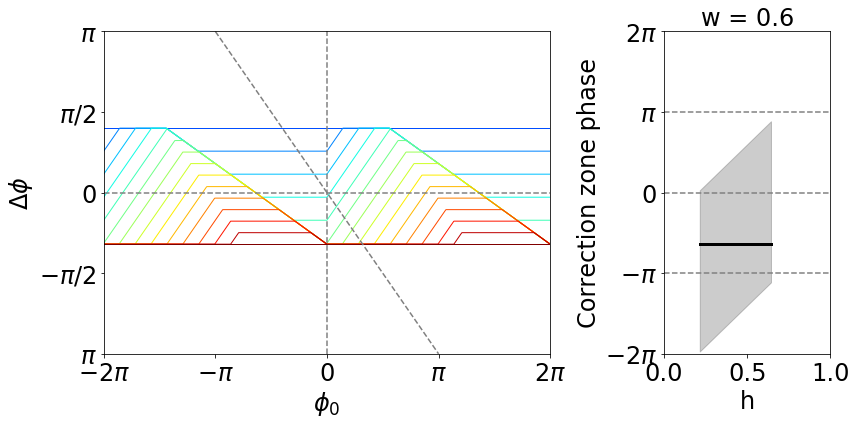

In [7]:
v_f = 1.2
v_s = 0.6

h = np.linspace(0, 1, 15)
w = 0.6

stb = np.zeros(len(h))
phi_stb = np.nan * np.zeros(len(h))
lb = np.nan * np.zeros(len(h))
ub = np.nan * np.zeros(len(h))

gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(12, 6), tight_layout=True)
axs = [fig.add_subplot(gs[:-1]), fig.add_subplot(gs[-1])]

c = get_ordered_colors('jet', len(h), .2, 1)

for ch, (h_, c_) in enumerate(zip(h, c)):
    # check stability
    stb[ch] = chk_stb(w, h_, v_f, v_s)
    
    # calc and store attractor basin
    if stb[ch]:
        _, x_0_stb_, _, lb_, ub_ = get_basin(w, h_, v_f, v_s)
        
        phi_stb[ch] = 2*np.pi*(x_0_stb_-1)
        lb[ch] = 2*np.pi*lb_
        ub[ch] = 2*np.pi*ub_
        
    # plot stability map
    dx_s = np.array([calc_dx_s(x_0, w, h_, v_f, v_s) for x_0 in X_0])
    axs[0].plot(2*np.pi*X_0, 2*np.pi*dx_s, lw=1, c=c_, zorder=0)

axs[0].axhline(0, color='gray', ls='--')
axs[0].axvline(0, color='gray', ls='--')
axs[0].plot([-np.pi, np.pi], [np.pi, -np.pi], c='gray', ls='--')

axs[0].set_xlim(-2*np.pi, 2*np.pi)
axs[0].set_ylim(-np.pi, np.pi)

axs[0].set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[0].set_xticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])
axs[0].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axs[0].set_yticklabels(['$\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].set_xlabel('$\phi_0$')
axs[0].set_ylabel('$\Delta \phi$')

axs[1].plot(h, phi_stb, lw=3, c='k')
axs[1].fill_between(h, phi_stb+lb, phi_stb+ub, color='k', alpha=.2)
axs[1].axhline(np.pi, color='gray', ls='--')
axs[1].axhline(0, color='gray', ls='--')
axs[1].axhline(-np.pi, color='gray', ls='--')
axs[1].set_xlim(0, 1)
axs[1].set_ylim(-2*np.pi, 2*np.pi)

axs[1].set_xticks([0, .5, 1])
axs[1].set_yticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[1].set_yticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])

axs[1].set_xlabel('h')
axs[1].set_ylabel('Correction zone phase')
axs[1].set_title('w = {}'.format(w))

for ax in axs:
    set_font_size(ax, 24)
    
fig.savefig('cosyne_poster_figs/fig2c2.svg')

Vary v_s

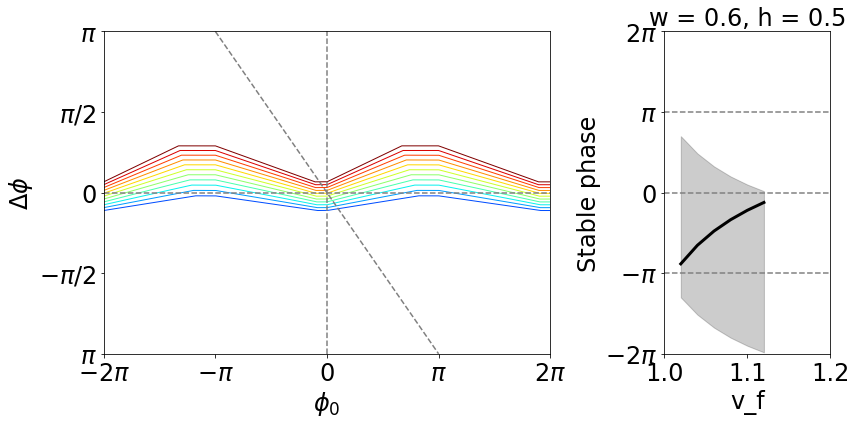

In [8]:
v_f = np.linspace(1, 1.2, 11)
v_s = 0.9

h = 0.5
w = 0.6

stb = np.zeros(len(v_f))
phi_stb = np.nan * np.zeros(len(v_f))
lb = np.nan * np.zeros(len(v_f))
ub = np.nan * np.zeros(len(v_f))

gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(12, 6), tight_layout=True)
axs = [fig.add_subplot(gs[:-1]), fig.add_subplot(gs[-1])]

c = get_ordered_colors('jet', len(v_f), .2, 1)

for ch, (v_f_, c_) in enumerate(zip(v_f, c)):
    # check stability
    stb[ch] = chk_stb(w, h, v_f_, v_s)
    
    # calc and store attractor basin
    if stb[ch]:
        _, x_0_stb_, _, lb_, ub_ = get_basin(w, h, v_f_, v_s)
        
        phi_stb[ch] = 2*np.pi*(x_0_stb_-1)
        lb[ch] = 2*np.pi*lb_
        ub[ch] = 2*np.pi*ub_
        
    # plot stability map
    dx_s = np.array([calc_dx_s(x_0, w, h, v_f_, v_s) for x_0 in X_0])
    axs[0].plot(2*np.pi*X_0, 2*np.pi*dx_s, lw=1, c=c_, zorder=0)

axs[0].axhline(0, color='gray', ls='--')
axs[0].axvline(0, color='gray', ls='--')
axs[0].plot([-np.pi, np.pi], [np.pi, -np.pi], c='gray', ls='--')

axs[0].set_xlim(-2*np.pi, 2*np.pi)
axs[0].set_ylim(-np.pi, np.pi)

axs[0].set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[0].set_xticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])
axs[0].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
axs[0].set_yticklabels(['$\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].set_xlabel('$\phi_0$')
axs[0].set_ylabel('$\Delta \phi$')

axs[1].plot(v_f, phi_stb, lw=3, c='k')
axs[1].fill_between(v_f, phi_stb+lb, phi_stb+ub, color='k', alpha=.2)
axs[1].axhline(np.pi, color='gray', ls='--')
axs[1].axhline(0, color='gray', ls='--')
axs[1].axhline(-np.pi, color='gray', ls='--')
axs[1].set_xlim(1, 1.2)
axs[1].set_ylim(-2*np.pi, 2*np.pi)

axs[1].set_xticks([1, 1.1, 1.2])
axs[1].set_yticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[1].set_yticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])

axs[1].set_xlabel('v_f')
axs[1].set_ylabel('Stable phase')
axs[1].set_title('w = {}, h = {}'.format(w, h))

for ax in axs:
    set_font_size(ax, 24)

Vary v_f and v_s together at fixed ratio.

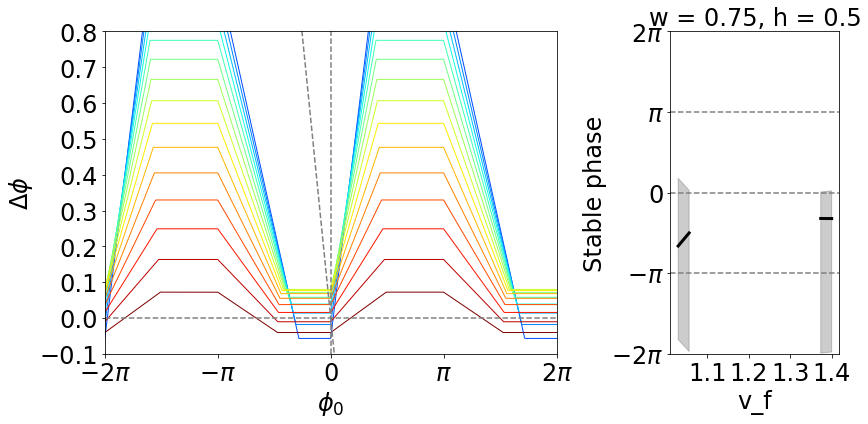

In [9]:
v_f = np.linspace(1.4, 1.03, 15)
v_s = np.linspace(.77, .96, 15)

h = 0.5
w = 0.75

stb = np.zeros(len(v_f))
phi_stb = np.nan * np.zeros(len(v_f))
lb = np.nan * np.zeros(len(v_f))
ub = np.nan * np.zeros(len(v_f))

gs = gridspec.GridSpec(1, 3)
fig = plt.figure(figsize=(12, 6), tight_layout=True)
axs = [fig.add_subplot(gs[:-1]), fig.add_subplot(gs[-1])]

c = get_ordered_colors('jet', len(v_f), .2, 1)

for ch, (v_f_, v_s_, c_) in enumerate(zip(v_f, v_s, c)):
    # check stability
    stb[ch] = chk_stb(w, h, v_f_, v_s_)
    
    # calc and store attractor basin
    if stb[ch]:
        _, x_0_stb_, _, lb_, ub_ = get_basin(w, h, v_f_, v_s_)
        
        phi_stb[ch] = 2*np.pi*(x_0_stb_-1)
        lb[ch] = 2*np.pi*lb_
        ub[ch] = 2*np.pi*ub_
        
    # plot stability map
    dx_s = np.array([calc_dx_s(x_0, w, h, v_f_, v_s_) for x_0 in X_0])
    axs[0].plot(2*np.pi*X_0, 2*np.pi*dx_s, lw=1, c=c_, zorder=0)

axs[0].axhline(0, color='gray', ls='--')
axs[0].axvline(0, color='gray', ls='--')
axs[0].plot([-np.pi, np.pi], [np.pi, -np.pi], c='gray', ls='--')

axs[0].set_xlim(-2*np.pi, 2*np.pi)
axs[0].set_ylim(-.1, .8)

axs[0].set_xticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[0].set_xticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])
#axs[0].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
#axs[0].set_yticklabels(['$\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'])

axs[0].set_xlabel('$\phi_0$')
axs[0].set_ylabel('$\Delta \phi$')

axs[1].plot(v_f, phi_stb, lw=3, c='k')
axs[1].fill_between(v_f, phi_stb+lb, phi_stb+ub, color='k', alpha=.2)
axs[1].axhline(np.pi, color='gray', ls='--')
axs[1].axhline(0, color='gray', ls='--')
axs[1].axhline(-np.pi, color='gray', ls='--')

axs[1].set_ylim(-2*np.pi, 2*np.pi)

axs[1].set_yticks([-2*np.pi, -np.pi, 0, np.pi, 2*np.pi])
axs[1].set_yticklabels(['$-2\pi$', '$-\pi$', '0', '$\pi$', '$2\pi$'])

axs[1].set_xlabel('v_f')
axs[1].set_ylabel('Stable phase')
axs[1].set_title('w = {}, h = {}'.format(w, h))

for ax in axs:
    set_font_size(ax, 24)

# Stability regime in v_f - v_s space

For each $(v_f, v_s)$ we find the $w$ and $h$ yielding the most centered attractor basin.

We plot $w$, $h$, $x_0^{stb}$, lb, ub, and lb + ub

In [10]:
v_f = np.linspace(.9,1.5, 101)
v_s = np.linspace(.5, 1.1, 101)
w = np.linspace(.6, .6, 1)
h = np.linspace(.5, .5, 1)
#w = np.linspace(.3, .7, 16)
#h = np.linspace(.3, .7, 16)

t2stb = np.nan * np.zeros((len(v_f), len(v_s)))
t2w = np.nan * np.zeros((len(v_f), len(v_s)))
t2h = np.nan * np.zeros((len(v_f), len(v_s)))
t2x_0_stb = np.nan * np.zeros((len(v_f), len(v_s)))
t2lb = np.nan * np.zeros((len(v_f), len(v_s)))
t2ub = np.nan * np.zeros((len(v_f), len(v_s)))

for cv_f, v_f_ in enumerate(v_f):
    for cv_s, v_s_ in enumerate(v_s):
        stb_best = False
        offset_best = np.inf  # centrality of stable point
        
        x_0_stb_best = np.nan
        w_best = np.nan
        h_best = np.nan
        lb_best = np.nan
        ub_best = np.nan
        
        for cw, w_ in enumerate(w):
            for ch, h_ in enumerate(h):
                
                if not chk_stb(w_, h_, v_f_, v_s_):
                    continue
                    
                stb_best = True

                _, x_0_stb_, _, lb_, ub_ = get_basin(w_, h_, v_f_, v_s_)

                offset = lb_ + ub_
                
                if np.abs(offset) < np.abs(offset_best):
                    offset_best = offset
                    x_0_stb_best = x_0_stb_
                    w_best = w_
                    h_best = h_
                    lb_best = lb_
                    ub_best = ub_
        
        # store vals corresponding to most centered basin in matrices
        t2stb[cv_f, cv_s] = stb_best
        t2w[cv_f, cv_s] = w_best
        t2h[cv_f, cv_s] = h_best
        t2x_0_stb[cv_f, cv_s] = x_0_stb_best
        t2lb[cv_f, cv_s] = lb_best
        t2ub[cv_f, cv_s] = ub_best

/home/z051m/miniconda3/envs/sci/lib/python3.6/site-packages/ipykernel_launcher.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


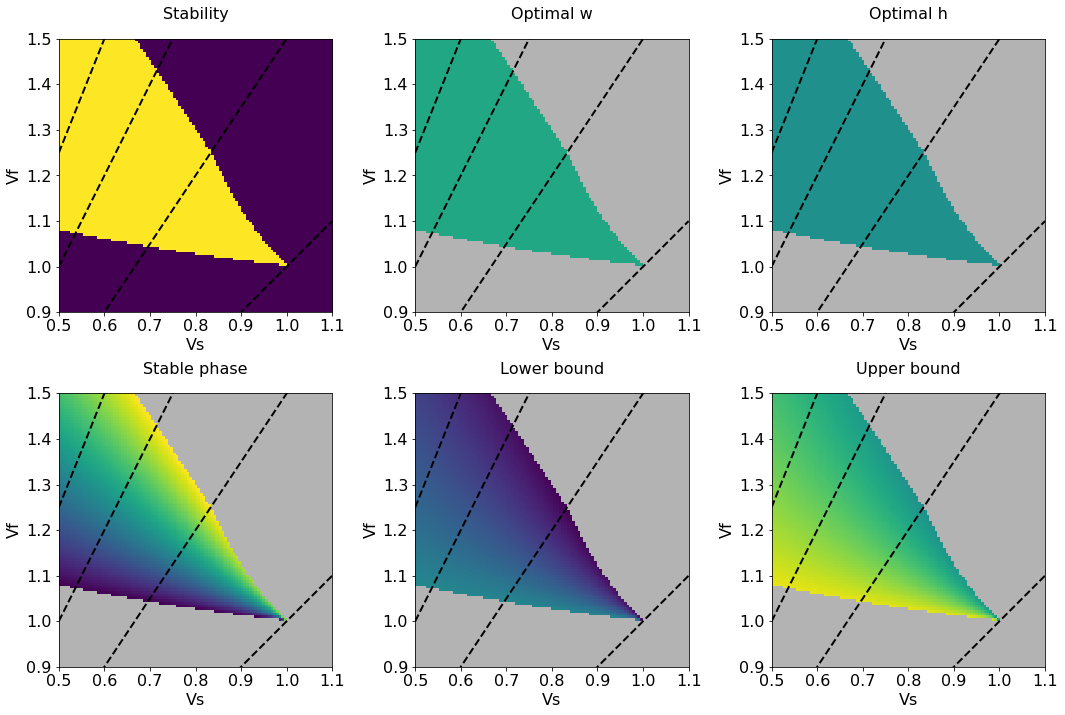

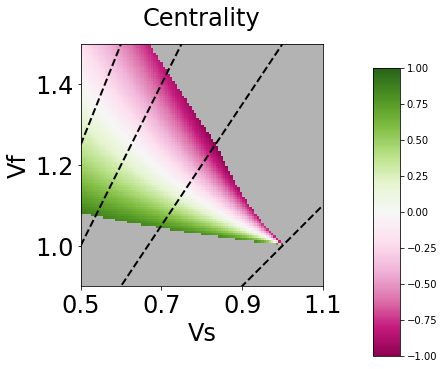

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10), tight_layout=True)
axs = axs.flatten()

axs[0].matshow(
    t2stb, origin='lower', vmin=0, vmax=1,
    extent=[v_s.min(), v_s.max(), v_f.min(), v_f.max()])
axs[0].xaxis.tick_bottom()
axs[0].set_title('Stability')

axs[1].matshow(
    t2w, origin='lower', vmin=0, vmax=1,
    extent=[v_s.min(), v_s.max(), v_f.min(), v_f.max()])
axs[1].xaxis.tick_bottom()
axs[1].set_title('Optimal w')

axs[2].matshow(
    t2h, origin='lower', vmin=0, vmax=1,
    extent=[v_s.min(), v_s.max(), v_f.min(), v_f.max()])
axs[2].xaxis.tick_bottom()
axs[2].set_title('Optimal h')

axs[3].matshow(
    t2x_0_stb, origin='lower',
    extent=[v_s.min(), v_s.max(), v_f.min(), v_f.max()])
axs[3].xaxis.tick_bottom()
axs[3].set_title('Stable phase')

axs[4].matshow(
    t2lb, origin='lower', vmin=-1, vmax=1,
    extent=[v_s.min(), v_s.max(), v_f.min(), v_f.max()])
axs[4].xaxis.tick_bottom()
axs[4].set_title('Lower bound')

axs[5].matshow(
    t2ub, origin='lower', vmin=-1, vmax=1,
    extent=[v_s.min(), v_s.max(), v_f.min(), v_f.max()])
axs[5].xaxis.tick_bottom()
axs[5].set_title('Upper bound')

for ax in axs:
    for f in [1, 1.5, 2, 2.5]:
        ax.plot(v_s, f*v_s, c='k', lw=2, ls='--')
    ax.set_xlim(v_s.min(), v_s.max())
    ax.set_ylim(v_f.min(), v_f.max())
    ax.set_xlabel('Vs')
    ax.set_ylabel('Vf')
    
    ax.set_facecolor((.7, .7, .7))
    
    set_font_size(ax, 16)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

im = ax.matshow(
    t2lb + t2ub, origin='lower', vmin=-1, vmax=1, cmap='PiYG',
    extent=[v_s.min(), v_s.max(), v_f.min(), v_f.max()])

ax.xaxis.tick_bottom()

for f in [1, 1.5, 2, 2.5]:
    ax.plot(v_s, f*v_s, c='k', lw=2, ls='--')
    
ax.set_xlim(v_s.min(), v_s.max())
ax.set_ylim(v_f.min(), v_f.max())

ax.set_xticks([.5, .7, .9, 1.1])
ax.set_yticks([1, 1.2, 1.4])
ax.set_xlabel('Vs')
ax.set_ylabel('Vf')
ax.set_title('Centrality')

ax.set_facecolor((.7, .7, .7))
cax = plt.axes([1.05, 0, 0.075, 0.8])
plt.colorbar(im, cax=cax)

set_font_size(ax, 24)
fig.savefig('cosyne_poster_figs/fig2e.svg')